# Introduction
This is an attempt to reboot the Pf3k paper. Here we analyse the 5 samples that are included in both the short-read (SR) and long-read (LR) call sets. Although PacBio assemblies were created for 15 samples, we decided only to inlcude 5 of these in the comparative analyses. Note that the LR call sets are created using essentially the same pipeline as the SR calls, but with no filtering of variants. The raw data for the LR call set is a set of bams files created by Thomas by splitting the PacBio assemblies into 50kb "reads" in such a way that there is 14x coverage (7 forward and 7 reverse).

Here we undertake the following analyses:
1. Determine numbers of variants in the following five categories across all 5 samples:
    - PASS SR variants called in LR set
    - FAIL SR variants called in LR set
    - PASS SR variants not called in LR set
    - FAIL SR variants not called in LR set
    - LR variants not called in SR set
    Variants will be considered to match if they have the same position and alternate alleles, else to be different
1. Determine numbers of variants in above five categories for each sample individually and sum across all five
1. Above broken down by (10kb?) windows across the genome
1. Above broken down by:
    - Coding SNP
    - Coding indel
    - Intronic SNP
    - Intronic indel
    - Intergenic SNP
    - Intergenic indel
    - NonCore SNP
    - NonCore indel
    

In [1]:
%run _standard_imports.ipynb
%run ../2017/_plotting_setup.ipynb

python 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.13.3
scipy 0.19.1
pandas 0.22.0
numexpr 2.6.4
pysam 0.8.4
petl 1.1.0
petlx 1.0.3
vcf 0.6.8
vcfnp 2.3.0
h5py 2.7.0
tables 3.4.2


# Setup

In [2]:
output_dir = '/lustre/scratch118/malaria/team112/personal/rp7/data/methods-dev/pf3k_techbm/20180717_SR_vs_LR_analysis'
!mkdir -p {output_dir}/vcf
!mkdir -p {output_dir}/zarr

sr_vcf_fn = "%s/vcf/SR_5_samples.vcf.gz" % output_dir
lr_vcf_fn = "/nfs/team112_internal/rp7/data/pf3k/pacbio_3/vcf/pf3k_pacbio_3.vcf.gz" # See 20161012_pf3k_pacbio_3_setup.ipynb
release5_final_files_dir = '/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0'
wg_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.vcf.gz" % (release5_final_files_dir)
# crosses_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.crosses.vcf.gz" % (release5_final_files_dir)

gff_fn = '/lustre/scratch118/malaria/team112/personal/rp7/data/methods-dev/pf3k_techbm/20180108_call_set_summaries_HDF5/Pfalciparum.noseq.ascii.gff3.gz'
regions_fn = "/nfs/team112_internal/rp7/src/github/malariagen/pf-crosses/meta/regions-20130225.bed.gz"
   
sr_zarr_fn = "%s/zarr/SR_5_samples" % output_dir
lr_zarr_fn = "%s/zarr/LR_5_samples" % output_dir


In [3]:
# These are the samples which we will compare with PacBio assemblies
fdr_samples = collections.OrderedDict()
fdr_samples['Pf7G8'] = '7G8' # This is 76bp crosses parent
fdr_samples['PfGB4'] = 'GB4' # This is 76bp crosses parent
fdr_samples['PfGN01'] = 'ERS740940' # This is 100bp version created from 250bp MiSeq data
fdr_samples['PfKE01'] = 'ERS740937' # This is 100bp version created from 250bp MiSeq data
fdr_samples['PfKH02'] = 'ERS740936' # This is 100bp version created from 250bp MiSeq data, There is also 76bp originally sequenced sample (PH0197-C)

In [4]:
sr_samples = ','.join(fdr_samples.values())
sr_samples

'7G8,GB4,ERS740940,ERS740937,ERS740936'

# Create subset VCF of 5 samples
Note we remove any position or allele that is not segregating using ```--min-ac 1 --trim-alt-alleles```. We also normalize to left-align indels, and remove any remaining variant where the only ALT allele is a spanning deletion.

# Create zarr files

In [5]:
import allel
import zarr

In [6]:
allel.vcf_to_zarr(
    sr_vcf_fn,
    sr_zarr_fn,
    alt_number=6,
    fields='*',
    log=sys.stdout,
    overwrite=True
)

[vcf_to_zarr] 65536 rows in 2.32s; chunk in 2.32s (28220 rows/s); Pf3D7_05_v3 :326930
[vcf_to_zarr] 131072 rows in 7.45s; chunk in 5.13s (12777 rows/s); Pf3D7_08_v3 :1436350
[vcf_to_zarr] 196608 rows in 10.97s; chunk in 3.52s (18642 rows/s); Pf3D7_12_v3 :464878
[vcf_to_zarr] 258009 rows in 14.26s; chunk in 3.30s (18622 rows/s)
[vcf_to_zarr] all done (16719 rows/s)


In [7]:
allel.vcf_to_zarr(
    lr_vcf_fn,
    lr_zarr_fn,
    alt_number=6,
    fields='*',
    log=sys.stdout,
    overwrite=True
)

[vcf_to_zarr] 65536 rows in 1.04s; chunk in 1.04s (62740 rows/s); Pf3D7_08_v3 :909897
[vcf_to_zarr] 131072 rows in 3.83s; chunk in 2.78s (23561 rows/s); Pf3D7_13_v3 :2224911
[vcf_to_zarr] 154250 rows in 4.90s; chunk in 1.07s (21662 rows/s)
[vcf_to_zarr] all done (28121 rows/s)


In [8]:
callset_sr = zarr.open(sr_zarr_fn)
callset_lr = zarr.open(lr_zarr_fn)


In [9]:
callset_sr['samples'][:]

array(['7G8', 'GB4', 'ERS740940', 'ERS740937', 'ERS740936'], dtype=object)

In [10]:
callset_lr['samples'][:]

array(['Pf7G8', 'PfGB4', 'PfGN01', 'PfKE01', 'PfKH02'], dtype=object)

# Create genomic intervals table
This is a table where we divide the genome (14 autosomes only) into the following types of interval:

- NonCore
- Coding
- Intronic
- Intergenic

We later use these intervals to assign each variant to one of the above intervals

In [11]:
# Read in gff file
gff_attributes = ['ID', 'Parent']
df_gff = allel.gff3_to_dataframe(gff_fn, gff_attributes).replace(b'.', '.')
print(df_gff.shape)
print(df_gff.loc[df_gff['type'] == 'CDS'].shape)
df_gff.loc[df_gff['type'] == 'CDS'][0:5]

(31978, 10)
(14372, 10)


,seqid,source,type,start,end,score,strand,phase,ID,Parent
8,Pf3D7_01_v3,chado,CDS,29510,34762,-1,+,0,PF3D7_0100100.1:exon:1,PF3D7_0100100.1
9,Pf3D7_01_v3,chado,CDS,35888,37126,-1,+,0,PF3D7_0100100.1:exon:2,PF3D7_0100100.1
14,Pf3D7_01_v3,chado,CDS,38982,39923,-1,-,0,PF3D7_0100200.1:exon:1,PF3D7_0100200.1
16,Pf3D7_01_v3,chado,CDS,40154,40207,-1,-,0,PF3D7_0100200.1:exon:2,PF3D7_0100200.1
20,Pf3D7_01_v3,chado,CDS,42367,43617,-1,-,0,PF3D7_0100300.1:exon:1,PF3D7_0100300.1


In [12]:
# Sanity check of different types
df_gff['type'].value_counts(dropna=False)

CDS                       14372
gene                       5561
polypeptide                5536
mRNA                       5383
pseudogenic_exon            461
pseudogene                  153
pseudogenic_transcript      153
tRNA                         79
rRNA                         71
ncRNA                        57
repeat_region                55
snoRNA                       40
polypeptide_motif            39
centromere                   13
snRNA                         5
Name: type, dtype: int64

In [13]:
# Create a DataFrame of all the appropriate coding regions (we exclude non-polypeptide coding regions and
# include only first splice variant in the few cases where there are more than one)
df_cds = df_gff.loc[
    (df_gff['type'] == 'CDS') & # Only want coding sequences
    df_gff['Parent'].isin(df_gff.loc[df_gff['type'] == 'polypeptide', 'ID'].str.replace(':pep', '')) & # Only coding sequences of polypeptides (not pseudogene, ncRNA, etc.)
    (df_gff['Parent'].str.endswith('.1')) & # Only want first splice variant
    (df_gff['ID'] != 'PF3D7_0528500.1:exon:10') # This exon is completely within PF3D7_0528600 which is on the other strand
].sort_values(['seqid', 'start', 'end'])
print(df_cds.shape)
df_cds[25:35]

(13482, 10)


,seqid,source,type,start,end,score,strand,phase,ID,Parent
104,Pf3D7_01_v3,chado,CDS,87203,88003,-1,-,0,PF3D7_0101800.1:exon:1,PF3D7_0101800.1
105,Pf3D7_01_v3,chado,CDS,88109,88177,-1,-,0,PF3D7_0101800.1:exon:2,PF3D7_0101800.1
110,Pf3D7_01_v3,chado,CDS,90242,91204,-1,-,0,PF3D7_0101900.1:exon:1,PF3D7_0101900.1
111,Pf3D7_01_v3,chado,CDS,91352,91420,-1,-,0,PF3D7_0101900.1:exon:2,PF3D7_0101900.1
129,Pf3D7_01_v3,chado,CDS,98819,99013,-1,+,0,PF3D7_0102200.1:exon:1,PF3D7_0102200.1
130,Pf3D7_01_v3,chado,CDS,99220,102282,-1,+,0,PF3D7_0102200.1:exon:2,PF3D7_0102200.1
135,Pf3D7_01_v3,chado,CDS,104704,104775,-1,+,0,PF3D7_0102300.1:exon:1,PF3D7_0102300.1
136,Pf3D7_01_v3,chado,CDS,104928,105209,-1,+,0,PF3D7_0102300.1:exon:2,PF3D7_0102300.1
145,Pf3D7_01_v3,chado,CDS,110750,110823,-1,-,2,PF3D7_0102500.1:exon:1,PF3D7_0102500.1
146,Pf3D7_01_v3,chado,CDS,110962,111050,-1,-,1,PF3D7_0102500.1:exon:2,PF3D7_0102500.1


In [14]:
# Read in regions file so we know which is the core genome
df_regions = pd.read_csv(regions_fn, sep='\t', names=['chrom', 'start', 'end', 'region_type'])
print(df_regions.shape)
df_regions[0:10]

(110, 4)


,chrom,start,end,region_type
0,Pf3D7_01_v3,0,27336,SubtelomericRepeat
1,Pf3D7_01_v3,27336,92900,SubtelomericHypervariable
2,Pf3D7_01_v3,92900,457931,Core
3,Pf3D7_01_v3,457931,460311,Centromere
4,Pf3D7_01_v3,460311,575900,Core
5,Pf3D7_01_v3,575900,616691,SubtelomericHypervariable
6,Pf3D7_01_v3,616691,640851,SubtelomericRepeat
7,Pf3D7_02_v3,0,23100,SubtelomericRepeat
8,Pf3D7_02_v3,23100,105800,SubtelomericHypervariable
9,Pf3D7_02_v3,105800,447300,Core


In [15]:
# Find chromosome sizes so we can ensure NonCore region goes to end of chromosome
chrom_sizes = df_regions.groupby('chrom').max()['end']
chrom_sizes

chrom
Pf3D7_01_v3     640851
Pf3D7_02_v3     947102
Pf3D7_03_v3    1067971
Pf3D7_04_v3    1200490
Pf3D7_05_v3    1343577
Pf3D7_06_v3    1418242
Pf3D7_07_v3    1445207
Pf3D7_08_v3    1472805
Pf3D7_09_v3    1541735
Pf3D7_10_v3    1687656
Pf3D7_11_v3    2038340
Pf3D7_12_v3    2271494
Pf3D7_13_v3    2925236
Pf3D7_14_v3    3291936
Name: end, dtype: int64

In [16]:
# Create DataFrame with core regions only
df_core = df_regions.loc[df_regions['region_type'] == 'Core']
print(df_core.shape)
df_core[0:5]

(34, 4)


,chrom,start,end,region_type
2,Pf3D7_01_v3,92900,457931,Core
4,Pf3D7_01_v3,460311,575900,Core
9,Pf3D7_02_v3,105800,447300,Core
11,Pf3D7_02_v3,450450,862500,Core
16,Pf3D7_03_v3,70630,597816,Core


In [17]:
# Create lists to hold values for different genomic regions
# This is quite involved. In essence we simply loop through core and CDS regions, and write out appropriate genomic
# regions
chroms = list()
starts = list()
ends = list()
genomic_regions = list()

current_chrom = 'Pf3D7_01_v3'
current_pos = 1
cds_iter = df_cds.iterrows()
next_cds = next(cds_iter)[1]
current_parent = next_cds['Parent']
current_region = 'Intergenic'
for index, next_core in df_core.iterrows():
    if next_core['chrom'] != current_chrom:
        chroms.append(current_chrom)
        starts.append(next_cds['end'])
        ends.append(chrom_sizes[current_chrom])
        genomic_regions.append('NonCore')
        current_chrom = next_core['chrom']
        current_pos = 1
    if current_pos < next_core['start']:
        chroms.append(current_chrom)
        starts.append(current_pos)
        ends.append(next_core['start'])
        genomic_regions.append('NonCore')
        current_pos = next_core['start']
    while (current_pos < next_core['end']) and (current_chrom == next_core['chrom']):
        while next_cds['end'] < current_pos or next_cds['seqid'] < current_chrom:
            next_cds = next(cds_iter)[1]
            if next_cds['Parent'] == current_parent:
                current_region = 'Intronic'
            else:
                current_region = 'Intergenic'
                current_parent = next_cds['Parent']
        if current_pos > next_cds['start']:
            chroms.append(current_chrom)
            starts.append(current_pos)
            ends.append(next_cds['end'])
            genomic_regions.append('Coding')
            current_pos = next_cds['end']
        else:
            # add region up until this CDS
            chroms.append(current_chrom)
            starts.append(current_pos)
            ends.append(next_cds['start'])
            genomic_regions.append(current_region)
            # add region for this CDS
            chroms.append(current_chrom)
            starts.append(next_cds['start'])
            ends.append(next_cds['end'])
            genomic_regions.append('Coding')
            current_pos = next_cds['end']
        while next_cds['end'] < next_core['end']:
            next_cds = next(cds_iter)[1]
            if next_cds['Parent'] == current_parent:
                current_region = 'Intronic'
            else:
                current_region = 'Intergenic'
                current_parent = next_cds['Parent']
            if current_pos > next_cds['start']:
                chroms.append(current_chrom)
                starts.append(current_pos)
                ends.append(next_cds['end'])
                genomic_regions.append('Coding')
                current_pos = next_cds['end']
            else:
                # add region up until this CDS
                chroms.append(current_chrom)
                starts.append(current_pos)
                ends.append(next_cds['start'])
                genomic_regions.append(current_region)
                # add region for this CDS
                chroms.append(current_chrom)
                starts.append(next_cds['start'])
                ends.append(next_cds['end'])
                genomic_regions.append('Coding')
                current_pos = next_cds['end']
chroms.append(current_chrom)
starts.append(next_cds['end'])
ends.append(chrom_sizes[current_chrom])
genomic_regions.append('NonCore')


In [18]:
genomic_regions_dict = collections.OrderedDict()
genomic_regions_dict['chrom'] = chroms
genomic_regions_dict['pos'] = pd.IntervalIndex.from_arrays(starts, ends)
# genomic_regions_dict['start'] = starts
# genomic_regions_dict['end'] = ends
genomic_regions_dict['genomic_region'] = genomic_regions
df_genomic_regions = pd.DataFrame(genomic_regions_dict).set_index(['chrom', 'pos'])
# df_genomic_regions['pos'] = pd.IntervalIndex.from_arrays(starts, ends)
# df_genomic_regions.set_index(['chrom', 'pos'], inplace=True)
print(df_genomic_regions.shape)
df_genomic_regions[590:600]

(25679, 1)


genomic_region
chrom       pos                            
Pf3D7_01_v3 (564842, 569485]     Intergenic
            (569485, 570048]         Coding
            (570048, 570204]       Intronic
            (570204, 570272]         Coding
            (570272, 577704]     Intergenic
            (577704, 578496]         Coding
            (578496, 640851]        NonCore
Pf3D7_02_v3 (1, 105800]             NonCore
            (105800, 109564]     Intergenic
            (109564, 110283]         Coding

In [19]:
df_genomic_regions.tail()

genomic_region
chrom       pos                              
Pf3D7_14_v3 (3243448, 3243573]       Intronic
            (3243573, 3243629]         Coding
            (3243629, 3254092]     Intergenic
            (3254092, 3256554]         Coding
            (3256554, 3291936]        NonCore

In [20]:
# Sanity check
df_genomic_regions['genomic_region'].value_counts(dropna=False)

Coding        12833
Intronic       7914
Intergenic     4897
NonCore          35
Name: genomic_region, dtype: int64

In [21]:
# Sanity check
df_genomic_regions.reset_index()['chrom'].value_counts()

Pf3D7_14_v3    3961
Pf3D7_13_v3    3312
Pf3D7_12_v3    2514
Pf3D7_11_v3    2413
Pf3D7_10_v3    1908
Pf3D7_09_v3    1858
Pf3D7_08_v3    1554
Pf3D7_06_v3    1534
Pf3D7_05_v3    1515
Pf3D7_07_v3    1296
Pf3D7_03_v3    1184
Pf3D7_04_v3    1075
Pf3D7_02_v3     958
Pf3D7_01_v3     597
Name: chrom, dtype: int64

# Create all samples analysis table

In [22]:
def create_variants_table(callset=callset_sr):
    df_variants = pd.DataFrame(
        {
            'CHROM': pd.Series(
                callset['variants']['CHROM'][:],
                dtype="category"
            ), 
            'POS': callset['variants']['POS'][:],
            'REF': callset['variants']['REF'][:],
            'ALT_0': callset['variants']['ALT'][:, 0],
            'ALT_1': callset['variants']['ALT'][:, 1],
            'ALT_2': callset['variants']['ALT'][:, 2],
            'ALT_3': callset['variants']['ALT'][:, 3],
            'ALT_4': callset['variants']['ALT'][:, 4],
            'ALT_5': callset['variants']['ALT'][:, 5],
            'FILTER_PASS': callset['variants']['FILTER_PASS'][:],
            'is_snp': callset['variants']['is_snp'][:],
            'numalt': callset['variants']['numalt'][:],
        }
    )
    df_variants.set_index(['CHROM', 'POS', 'REF', 'ALT_0', 'ALT_1', 'ALT_2', 'ALT_3', 'ALT_4', 'ALT_5'], inplace=True)
    return(df_variants)

In [23]:
%%time
bin_width = 10000

# Create initial table
df_all = create_variants_table(callset_sr).join(create_variants_table(callset_lr), how='outer', rsuffix='_LR')
print(df_all.shape)
# Fully populate is_snp
df_all.loc[df_all['is_snp'].isnull(), 'is_snp'] = df_all.loc[df_all['is_snp'].isnull(), 'is_snp_LR']
# Populate class
df_all['class'] = 'unknown'
df_all.loc[df_all['FILTER_PASS'] & df_all['FILTER_PASS_LR'].notnull(), 'class'] = 'PASS intersection'
df_all.loc[np.logical_not(df_all['FILTER_PASS']) & df_all['FILTER_PASS_LR'].notnull(), 'class'] = 'FAIL intersection'
df_all.loc[df_all['FILTER_PASS'] & df_all['FILTER_PASS_LR'].isnull(), 'class'] = 'PASS SR only'
df_all.loc[np.logical_not(df_all['FILTER_PASS']) & df_all['FILTER_PASS_LR'].isnull(), 'class'] = 'FAIL SR only'
df_all.loc[df_all['FILTER_PASS'].isnull(), 'class'] = 'LR only'
# Populate genomic bin
df_all['genomic_bin'] = np.array(df_all.reset_index()['POS']//bin_width)
# Populate genomic region
for chrom in ['Pf3D7_%02d_v3' % x for x in np.arange(1, 15)]:
    df_all.loc[chrom, 'genomic_region'] = np.array(
        df_genomic_regions
        .loc[chrom, 'genomic_region']
        .loc[df_all.loc[chrom].reset_index()['POS']]
    )
# Populate variant type
df_all['variant_type'] = df_all['genomic_region'].str.cat(df_all['is_snp'].map({True: 'SNP', False: 'indel'}), sep=' ')
print(df_all.shape)
df_all[0:3]

(332272, 6)
(332272, 10)
CPU times: user 7.88 s, sys: 212 ms, total: 8.1 s
Wall time: 8.03 s


In [24]:
df_all[0:3]

FILTER_PASS is_snp  \
CHROM       POS REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                      
Pf3D7_01_v3 522 C   T                                         False   True   
            525 TA  T                                         False  False   
            802 C   T                                         False   True   

                                                         numalt  \
CHROM       POS REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5           
Pf3D7_01_v3 522 C   T                                       1.0   
            525 TA  T                                       1.0   
            802 C   T                                       1.0   

                                                        FILTER_PASS_LR  \
CHROM       POS REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                  
Pf3D7_01_v3 522 C   T                                              NaN   
            525 TA  T                                              NaN   
            802 C   T                                              NaN   

                                                        is_snp_LR  numalt_LR  \
CHROM       POS REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                        
Pf3D7_01_v3 522 C   T                                         NaN        NaN   
            525 TA  T                                         NaN        NaN   
            802 C   T                                         NaN        NaN   

                                                                class  \
CHROM       POS REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                 
Pf3D7_01_v3 522 C   T                                    FAIL SR only   
            525 TA  T                                    FAIL SR only   
            802 C   T                                    FAIL SR only   

                                                         genomic_bin  \
CHROM       POS REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                
Pf3D7_01_v3 522 C   T                                              0   
            525 TA  T                                              0   
            802 C   T                                              0   

                                                        genomic_region  \
CHROM       POS REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                  
Pf3D7_01_v3 522 C   T                                          NonCore   
            525 TA  T                                          NonCore   
            802 C   T                                          NonCore   

                                                          variant_type  
CHROM       POS REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                 
Pf3D7_01_v3 522 C   T                                      NonCore SNP  
            525 TA  T                                    NonCore indel  
            802 C   T                                      NonCore SNP

In [25]:
# Sanity check
df_all.groupby(['genomic_region', 'class']).size()

genomic_region  class            
Coding          FAIL SR only           3638
                FAIL intersection      1554
                LR only               14407
                PASS SR only           4063
                PASS intersection     23646
Intergenic      FAIL SR only          13362
                FAIL intersection      4150
                LR only               40589
                PASS SR only          19688
                PASS intersection     36200
Intronic        FAIL SR only           2383
                FAIL intersection       794
                LR only               11221
                PASS SR only           5140
                PASS intersection      8016
NonCore         FAIL SR only         129721
                FAIL intersection      5627
                LR only                8046
dtype: int64

In [26]:
# Sanity check
df_all.groupby(['variant_type', 'class']).size()

variant_type      class            
Coding SNP        FAIL SR only           2674
                  FAIL intersection      1227
                  LR only                4337
                  PASS SR only           1496
                  PASS intersection     17876
Coding indel      FAIL SR only            964
                  FAIL intersection       327
                  LR only               10070
                  PASS SR only           2567
                  PASS intersection      5770
Intergenic SNP    FAIL SR only           8657
                  FAIL intersection      1961
                  LR only                2567
                  PASS SR only           1207
                  PASS intersection     13734
Intergenic indel  FAIL SR only           4705
                  FAIL intersection      2189
                  LR only               38022
                  PASS SR only          18481
                  PASS intersection     22466
Intronic SNP      FAIL SR only           155

# Create individual samples analysis table

In [27]:
def create_variants_table_sample(callset=callset_sr, sample='7G8', set_hets_false=True):
    column_index = np.where(callset['samples'][:] == sample)[0][0]
    if isinstance(column_index, int):
        return('No such sample')
    gda = allel.GenotypeDaskArray(callset['calldata']['GT'])
    is_het = gda.is_het()[:, column_index].compute()
    is_hom_alt = gda.is_hom_alt()[:, column_index].compute()
    is_non_ref = (is_het | is_hom_alt)
    df_variants = pd.DataFrame(
        {
            'CHROM': pd.Series(
                callset['variants']['CHROM'][:][is_non_ref],
                dtype="category"
            ), 
            'POS': callset['variants']['POS'][:][is_non_ref],
            'REF': callset['variants']['REF'][:][is_non_ref],
            'ALT_0': callset['variants']['ALT'][:][is_non_ref, 0],
            'ALT_1': callset['variants']['ALT'][:][is_non_ref, 1],
            'ALT_2': callset['variants']['ALT'][:][is_non_ref, 2],
            'ALT_3': callset['variants']['ALT'][:][is_non_ref, 3],
            'ALT_4': callset['variants']['ALT'][:][is_non_ref, 4],
            'ALT_5': callset['variants']['ALT'][:][is_non_ref, 5],
            'FILTER_PASS': callset['variants']['FILTER_PASS'][:][is_non_ref],
            'is_snp': callset['variants']['is_snp'][:][is_non_ref],
            'numalt': callset['variants']['numalt'][:][is_non_ref],
        }
    )
    if set_hets_false:
        df_variants.loc[is_het[is_non_ref], 'FILTER_PASS'] = False
    df_variants.set_index(['CHROM', 'POS', 'REF', 'ALT_0', 'ALT_1', 'ALT_2', 'ALT_3', 'ALT_4', 'ALT_5'], inplace=True)
    return(df_variants)

In [28]:
print(create_variants_table_sample(callset_sr)['FILTER_PASS'].value_counts())
print()
print(create_variants_table_sample(callset_sr, set_hets_false=False)['FILTER_PASS'].value_counts())


False    55496
True     36233
Name: FILTER_PASS, dtype: int64

False    51687
True     40042
Name: FILTER_PASS, dtype: int64


In [29]:
create_variants_table_sample(callset_sr, '7G8')[0:3]

FILTER_PASS  is_snp  \
CHROM       POS  REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                        
Pf3D7_01_v3 1126 T   A                                          False    True   
            1153 C   T                                          False    True   
            1157 T   C                                          False    True   

                                                          numalt  
CHROM       POS  REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5          
Pf3D7_01_v3 1126 T   A                                         1  
            1153 C   T                                         1  
            1157 T   C                                         1

In [30]:
create_variants_table_sample(callset_lr, 'Pf7G8')[0:3]

FILTER_PASS  \
CHROM       POS   REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                
Pf3D7_01_v3 91218 A   G                                          False   
            91222 C   T                                          False   
            91241 A   T                                          False   

                                                           is_snp  numalt  
CHROM       POS   REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                  
Pf3D7_01_v3 91218 A   G                                      True       1  
            91222 C   T                                      True       1  
            91241 A   T                                      True       1

In [31]:
def create_sample_comparison_table(sample='Pf7G8', set_hets_false=True, bin_width = 10000):
    # Create initial table
    df_all = (
        create_variants_table_sample(callset_sr, fdr_samples[sample])
        .join(create_variants_table_sample(callset_lr, sample), how='outer', rsuffix='_LR')
    )
    # Fully populate is_snp
    df_all.loc[df_all['is_snp'].isnull(), 'is_snp'] = df_all.loc[df_all['is_snp'].isnull(), 'is_snp_LR']
    # Populate class
    df_all['class'] = 'unknown'
    df_all.loc[df_all['FILTER_PASS'] & df_all['FILTER_PASS_LR'].notnull(), 'class'] = 'PASS intersection'
    df_all.loc[np.logical_not(df_all['FILTER_PASS']) & df_all['FILTER_PASS_LR'].notnull(), 'class'] = 'FAIL intersection'
    df_all.loc[df_all['FILTER_PASS'] & df_all['FILTER_PASS_LR'].isnull(), 'class'] = 'PASS SR only'
    df_all.loc[np.logical_not(df_all['FILTER_PASS']) & df_all['FILTER_PASS_LR'].isnull(), 'class'] = 'FAIL SR only'
    df_all.loc[df_all['FILTER_PASS'].isnull(), 'class'] = 'LR only'
    # Populate genomic bin
    df_all['genomic_bin'] = np.array(df_all.reset_index()['POS']//bin_width)
    # Populate genomic region
    for chrom in ['Pf3D7_%02d_v3' % x for x in np.arange(1, 15)]:
        df_all.loc[chrom, 'genomic_region'] = np.array(
            df_genomic_regions
            .loc[chrom, 'genomic_region']
            .loc[df_all.loc[chrom].reset_index()['POS']]
        )
    # Populate variant type
    df_all['variant_type'] = df_all['genomic_region'].str.cat(df_all['is_snp'].map({True: 'SNP', False: 'indel'}), sep=' ')
    return(df_all)


In [32]:
%%time
sample_comparison_table = collections.OrderedDict()
for sample in fdr_samples:
    sample_comparison_table[sample] = create_sample_comparison_table(sample)
    print(sample, sample_comparison_table[sample].shape)

Pf7G8 (135193, 10)
PfGB4 (148814, 10)
PfGN01 (125039, 10)
PfKE01 (109520, 10)
PfKH02 (123391, 10)
CPU times: user 21.4 s, sys: 596 ms, total: 21.9 s
Wall time: 21 s


# Analysis

## Venn diagram numbers - all samples

In [33]:
venn_diagrams_all_samples = collections.OrderedDict()
venn_diagrams_all_samples['All variants, genome-wide'] = df_all['class'].value_counts(dropna=False)
venn_diagrams_all_samples['All variants, core genome'] = df_all.loc[df_all['genomic_region'] != 'NonCore', 'class'].value_counts(dropna=False)
venn_diagrams_all_samples['SNPs, genome-wide'] = df_all.loc[df_all['is_snp'], 'class'].value_counts(dropna=False)
venn_diagrams_all_samples['SNPs, core genome'] = df_all.loc[df_all['variant_type'].isin(['Coding SNP', 'Intronic SNP', 'Intergenic SNP']), 'class'].value_counts(dropna=False)
venn_diagrams_all_samples['Coding SNPs, core genome'] = df_all.loc[df_all['variant_type'] == 'Coding SNP', 'class'].value_counts(dropna=False)

df_venn_diagrams_all_samples = pd.concat(venn_diagrams_all_samples, axis=1).T.loc[venn_diagrams_all_samples]
df_venn_diagrams_all_samples

,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
"All variants, genome-wide",149109,12125,74263,28913,67862
"All variants, core genome",19388,6498,66217,28913,67862
"SNPs, genome-wide",120122,8225,12349,3090,34071
"SNPs, core genome",12888,3490,7556,3074,34071
"Coding SNPs, core genome",2674,1227,4337,1496,17876


## Venn diagram numbers - individual samples and sum across

In [34]:
def create_venn_for_sample(sample='Pf7G8'):
    venn_diagrams = collections.OrderedDict()
    venn_diagrams['All variants, genome-wide'] = sample_comparison_table[sample]['class'].value_counts(dropna=False)
    venn_diagrams['All variants, core genome'] = sample_comparison_table[sample].loc[sample_comparison_table[sample]['genomic_region'] != 'NonCore', 'class'].value_counts(dropna=False)
    venn_diagrams['SNPs, genome-wide'] = sample_comparison_table[sample].loc[sample_comparison_table[sample]['is_snp'], 'class'].value_counts(dropna=False)
    venn_diagrams['SNPs, core genome'] = sample_comparison_table[sample].loc[sample_comparison_table[sample]['variant_type'].isin(['Coding SNP', 'Intronic SNP', 'Intergenic SNP']), 'class'].value_counts(dropna=False)
    venn_diagrams['Coding SNPs, core genome'] = sample_comparison_table[sample].loc[sample_comparison_table[sample]['variant_type'] == 'Coding SNP', 'class'].value_counts(dropna=False)

    df_venn_diagram = pd.concat(venn_diagrams, axis=1).T.loc[venn_diagrams]
    return(df_venn_diagram)    

In [35]:
from IPython.display import display
df_venn_for_sample = collections.OrderedDict()
for sample in fdr_samples:
    df_venn_for_sample[sample] = create_venn_for_sample(sample)
    print(sample)
    display(df_venn_for_sample[sample])
    print()
df_venn_sum_across_samples = (
    df_venn_for_sample['Pf7G8']
    .add(df_venn_for_sample['PfGB4'])
    .add(df_venn_for_sample['PfGN01'])
    .add(df_venn_for_sample['PfKE01'])
    .add(df_venn_for_sample['PfKH02'])
)
print("Sum across samples")
df_venn_sum_across_samples

Pf7G8


,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
"All variants, genome-wide",51674,3822,43464,12260,23973
"All variants, core genome",10824,2274,40522,12260,23973
"SNPs, genome-wide",39613,2373,4859,413,12157
"SNPs, core genome",5553,1087,3135,405,12157
"Coding SNPs, core genome",1111,350,1719,196,6456



PfGB4


,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
"All variants, genome-wide",64351,4362,43094,12681,24326
"All variants, core genome",12028,2388,39885,12681,24326
"SNPs, genome-wide",49294,2717,4876,446,12049
"SNPs, core genome",6050,1046,3054,443,12049
"Coding SNPs, core genome",1027,371,1837,241,6462



PfGN01


,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
"All variants, genome-wide",37817,3902,45075,13096,25149
"All variants, core genome",4792,2477,41892,13096,25149
"SNPs, genome-wide",30273,2459,4307,600,12162
"SNPs, core genome",2503,1280,2489,590,12162
"Coding SNPs, core genome",811,470,1338,273,6557



PfKE01


,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
"All variants, genome-wide",26345,4055,40799,12891,25430
"All variants, core genome",4222,2524,37659,12891,25430
"SNPs, genome-wide",20809,2544,4585,655,12370
"SNPs, core genome",2109,1258,2724,652,12370
"Coding SNPs, core genome",667,415,1609,390,6640



PfKH02


,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
"All variants, genome-wide",36826,4084,40797,14442,27242
"All variants, core genome",4935,2212,38144,14442,27242
"SNPs, genome-wide",29317,2613,3939,656,13464
"SNPs, core genome",2554,1062,2412,651,13464
"Coding SNPs, core genome",838,418,1418,336,7263



Sum across samples


,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
"All variants, genome-wide",217013,20225,213229,65370,126120
"All variants, core genome",36801,11875,198102,65370,126120
"SNPs, genome-wide",169306,12706,22566,2770,62202
"SNPs, core genome",18769,5733,13814,2741,62202
"Coding SNPs, core genome",4454,2024,7921,1436,33378


In [33]:
venn_diagrams_all_samples = collections.OrderedDict()
venn_diagrams_all_samples['All variants, genome-wide'] = df_all['class'].value_counts(dropna=False)
venn_diagrams_all_samples['All variants, core genome'] = df_all.loc[df_all['genomic_region'] != 'NonCore', 'class'].value_counts(dropna=False)
venn_diagrams_all_samples['SNPs, genome-wide'] = df_all.loc[df_all['is_snp'], 'class'].value_counts(dropna=False)
venn_diagrams_all_samples['SNPs, core genome'] = df_all.loc[df_all['variant_type'].isin(['Coding SNP', 'Intronic SNP', 'Intergenic SNP']), 'class'].value_counts(dropna=False)
venn_diagrams_all_samples['Coding SNPs, core genome'] = df_all.loc[df_all['variant_type'] == 'Coding SNP', 'class'].value_counts(dropna=False)

df_venn_diagrams_all_samples = pd.concat(venn_diagrams_all_samples, axis=1).T.loc[venn_diagrams_all_samples]
df_venn_diagrams_all_samples

,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
"All variants, genome-wide",149109,12125,74263,28913,67862
"All variants, core genome",19388,6498,66217,28913,67862
"SNPs, genome-wide",120122,8225,12349,3090,34071
"SNPs, core genome",12888,3490,7556,3074,34071
"Coding SNPs, core genome",2674,1227,4337,1496,17876


## Why are there less PASS SR only coding SNPs in sum across individual samples?
Note in the above "Sum across samples" table, there are 1,436 Coding SNPs that are PASS SR only, whereas in the all samples table in the previous cell, there are 1,496. The following illustrates that this is likely to be caused by het calls being classified as "non-PASS", where the variant actually passed filters.

In [36]:
# What are the first few Coding SNPs that are 'PASS SR only' in all samples?
print(df_all.loc[(df_all['variant_type'] == 'Coding SNP') & (df_all['class'] == 'PASS SR only')].iloc[0:5, 0:2])
# Which individual samples have this variant?
print()
for sample in fdr_samples:
    if 98866 in np.array(sample_comparison_table[sample].loc['Pf3D7_01_v3'].reset_index()['POS']):
        print(sample)
# FILTER_PASS status in all_samples file
print()
print(df_all.loc['Pf3D7_01_v3', 98866]['FILTER_PASS'])
# FILTER_PASS status in individual sample file
print()
print(sample_comparison_table['PfGN01'].loc['Pf3D7_01_v3', 98866]['FILTER_PASS'])
# What is the genotype of PfGN01 (ERS740940) at Pf3D7_01_v3:98866
print()
print(np.where((callset_sr['variants']['CHROM'][:] == 'Pf3D7_01_v3') & (callset_sr['variants']['POS'][:] == 98866))[0][0])
print(np.where(callset_sr['samples'][:] == 'ERS740940')[0][0])
print(callset_sr['calldata']['GT'][5268, 2])
# Can see that PfGN01 has het call at this position, and hence has been considered ~PASS

                                                           FILTER_PASS is_snp
CHROM       POS    REF ALT_0 ALT_1 ALT_2 ALT_3 ALT_4 ALT_5                   
Pf3D7_01_v3 98866  G   T                                          True   True
            98868  A   G     T                                    True   True
            98978  C   T                                          True   True
            100057 T   A                                          True   True
            100616 G   A                                          True   True

PfGN01

REF  ALT_0  ALT_1  ALT_2  ALT_3  ALT_4  ALT_5
G    T                                           True
Name: FILTER_PASS, dtype: object

REF  ALT_0  ALT_1  ALT_2  ALT_3  ALT_4  ALT_5
G    T                                           False
Name: FILTER_PASS, dtype: object

5268
2
[0 1]


## Summary tables - all samples

In [37]:
df_variant_type_summary = (
    pd.DataFrame(
        df_all
        .groupby(['variant_type', 'class'])
        .size()
    )
    .reset_index()
    .pivot_table(values=0, index=['variant_type'], columns=['class'])
    .fillna(0)
    .astype(int)
)
df_variant_type_summary

class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
variant_type,,,,,
Coding SNP,2674,1227,4337,1496,17876
Coding indel,964,327,10070,2567,5770
Intergenic SNP,8657,1961,2567,1207,13734
Intergenic indel,4705,2189,38022,18481,22466
Intronic SNP,1557,302,652,371,2461
Intronic indel,826,492,10569,4769,5555
NonCore SNP,107229,4735,4793,0,0
NonCore indel,22492,892,3253,0,0


In [38]:
df_variant_type_summary.sum()

class
FAIL SR only         149104
FAIL intersection     12125
LR only               74263
PASS SR only          28891
PASS intersection     67862
dtype: int64

In [39]:
variant_types = collections.OrderedDict()
variant_types['all'] = ['Coding', 'Intergenic', 'Intronic', 'NonCore']
variant_types['core'] = ['Coding', 'Intergenic', 'Intronic']
variant_types['non-core'] = ['NonCore']
variant_types['coding'] = ['Coding']
variant_types['non-coding'] = ['Intergenic', 'Intronic']
variant_types['intronic'] = ['Intronic']
variant_types['intergenic'] = ['Intergenic']

variant_type_categories = collections.OrderedDict()
variant_type_categories_snp = collections.OrderedDict()
for variant_type in variant_types:
    variant_type_categories[variant_type] = ["%s SNP" % x for x in variant_types[variant_type]] + ["%s indel" % x for x in variant_types[variant_type]]
    variant_type_categories_snp[variant_type] = ["%s SNP" % x for x in variant_types[variant_type]]


In [40]:
variant_type_summary_all = collections.OrderedDict()
for variant_type_category in variant_type_categories:
    variant_type_summary_all[variant_type_category] = df_variant_type_summary.loc[variant_type_categories[variant_type_category]].sum()
    
df_variant_type_summary_all = pd.concat(variant_type_summary_all, axis=1).T
# df_variant_type_summary_all = pd.concat(variant_type_summary_all, axis=1).T.loc[variant_types]
df_variant_type_summary_all

class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,149104,12125,74263,28891,67862
coding,3638,1554,14407,4063,23646
core,19383,6498,66217,28891,67862
intergenic,13362,4150,40589,19688,36200
intronic,2383,794,11221,5140,8016
non-coding,15745,4944,51810,24828,44216
non-core,129721,5627,8046,0,0


In [41]:
variant_type_summary_all_snp = collections.OrderedDict()
for variant_type_category in variant_type_categories_snp:
    variant_type_summary_all_snp[variant_type_category] = df_variant_type_summary.loc[variant_type_categories_snp[variant_type_category]].sum()
    
df_variant_type_summary_all_snp = pd.concat(variant_type_summary_all_snp, axis=1).T
df_variant_type_summary_all_snp

class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,120117,8225,12349,3074,34071
coding,2674,1227,4337,1496,17876
core,12888,3490,7556,3074,34071
intergenic,8657,1961,2567,1207,13734
intronic,1557,302,652,371,2461
non-coding,10214,2263,3219,1578,16195
non-core,107229,4735,4793,0,0


## Summary tables - individual samples and sum across

In [42]:
%%time
df_variant_type_summary_sample = collections.OrderedDict()
for sample in fdr_samples:
    df_variant_type_summary_sample[sample] = (
        pd.DataFrame(
            sample_comparison_table[sample]
            .groupby(['variant_type', 'class'])
            .size()
        )
        .reset_index()
        .pivot_table(values=0, index=['variant_type'], columns=['class'])
        .fillna(0)
        .astype(int)
    )


CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 162 ms


In [43]:
%%time
df_variant_type_summary_sample = collections.OrderedDict()
variant_type_summary_sample = collections.OrderedDict()
for sample in fdr_samples:
    df_variant_type_summary_sample[sample] = (
        pd.DataFrame(
            sample_comparison_table[sample]
            .groupby(['variant_type', 'class'])
            .size()
        )
        .reset_index()
        .pivot_table(values=0, index=['variant_type'], columns=['class'])
        .fillna(0)
        .astype(int)
    )
    
    variant_type_summary_sample[sample] = collections.OrderedDict()
    for variant_type_category in variant_type_categories:
        variant_type_summary_sample[sample][variant_type_category] = df_variant_type_summary_sample[sample].loc[variant_type_categories[variant_type_category]].sum()

    df_variant_type_summary_sample[sample] = pd.concat(variant_type_summary_sample[sample], axis=1).T
    print(sample)
    display(df_variant_type_summary_sample[sample])
    print()

df_variant_type_summary_sum_across_samples = (
    df_variant_type_summary_sample['Pf7G8']
    .add(df_variant_type_summary_sample['PfGB4'])
    .add(df_variant_type_summary_sample['PfGN01'])
    .add(df_variant_type_summary_sample['PfKE01'])
    .add(df_variant_type_summary_sample['PfKH02'])
)
print("Sum across samples")
display(df_variant_type_summary_sum_across_samples)


Pf7G8


class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,51671,3822,43464,12248,23973
coding,1591,443,6990,1302,8571
core,10821,2274,40522,12248,23973
intergenic,7575,1488,26464,8628,12741
intronic,1655,343,7068,2318,2661
non-coding,9230,1831,33532,10946,15402
non-core,40850,1548,2942,0,0



PfGB4


class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,64350,4362,43094,12675,24326
coding,1536,456,7129,1362,8508
core,12027,2388,39885,12675,24326
intergenic,8807,1596,25772,8957,13006
intronic,1684,336,6984,2356,2812
non-coding,10491,1932,32756,11313,15818
non-core,52323,1974,3209,0,0



PfGN01


class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,37815,3902,45075,13083,25149
coding,1093,611,6537,1470,8698
core,4790,2477,41892,13083,25149
intergenic,3122,1586,27911,9242,13593
intronic,575,280,7444,2371,2858
non-coding,3697,1866,35355,11613,16451
non-core,33025,1425,3183,0,0



PfKE01


class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,26343,4055,40799,12884,25430
coding,916,536,6592,1533,8869
core,4220,2524,37659,12884,25430
intergenic,2844,1698,24254,9065,13697
intronic,460,290,6813,2286,2864
non-coding,3304,1988,31067,11351,16561
non-core,22123,1531,3140,0,0



PfKH02


class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,36825,4084,40797,14432,27242
coding,1155,548,6543,1563,9625
core,4934,2212,38144,14432,27242
intergenic,3228,1367,24777,10340,14565
intronic,551,297,6824,2529,3052
non-coding,3779,1664,31601,12869,17617
non-core,31891,1872,2653,0,0



Sum across samples


class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,217004,20225,213229,65322,126120
coding,6291,2594,33791,7230,44271
core,36792,11875,198102,65322,126120
intergenic,25576,7735,129178,46232,67602
intronic,4925,1546,35133,11860,14247
non-coding,30501,9281,164311,58092,81849
non-core,180212,8350,15127,0,0


CPU times: user 284 ms, sys: 0 ns, total: 284 ms
Wall time: 278 ms


In [44]:
df_variant_type_summary_sample_sum = (
    df_variant_type_summary_sample['Pf7G8']
    .add(df_variant_type_summary_sample['PfGB4'])
    .add(df_variant_type_summary_sample['PfGN01'])
    .add(df_variant_type_summary_sample['PfKE01'])
    .add(df_variant_type_summary_sample['PfKH02'])
)
df_variant_type_summary_sample_sum  

class,FAIL SR only,FAIL intersection,LR only,PASS SR only,PASS intersection
all,217004,20225,213229,65322,126120
coding,6291,2594,33791,7230,44271
core,36792,11875,198102,65322,126120
intergenic,25576,7735,129178,46232,67602
intronic,4925,1546,35133,11860,14247
non-coding,30501,9281,164311,58092,81849
non-core,180212,8350,15127,0,0


# Genomic bin summaries

In [45]:
%%time
df_genomic_bin_summary = collections.OrderedDict()
for sample in fdr_samples:
    df_genomic_bin_summary[sample] = (
        pd.DataFrame(
            sample_comparison_table[sample]
            .reset_index()
            .groupby(['CHROM', 'genomic_bin', 'class'])
            .size()
        )
        .reset_index()
        .pivot_table(values=0, index=['CHROM', 'genomic_bin'], columns=['class'])
        .fillna(0)
        .astype(int)
    )

CPU times: user 548 ms, sys: 32 ms, total: 580 ms
Wall time: 579 ms


In [46]:
%%time
df_genomic_bin_summary_snp = collections.OrderedDict()
for sample in fdr_samples:
    df_genomic_bin_summary_snp[sample] = (
        pd.DataFrame(
            sample_comparison_table[sample]
            .loc[sample_comparison_table[sample]['is_snp']]
            .reset_index()
            .groupby(['CHROM', 'genomic_bin', 'class'])
            .size()
        )
        .reset_index()
        .pivot_table(values=0, index=['CHROM', 'genomic_bin'], columns=['class'])
        .fillna(0)
        .astype(int)
    )

CPU times: user 352 ms, sys: 0 ns, total: 352 ms
Wall time: 350 ms


In [47]:
%%time
df_genomic_bin_summary_coding_snp = collections.OrderedDict()
for sample in fdr_samples:
    df_genomic_bin_summary_coding_snp[sample] = (
        pd.DataFrame(
            sample_comparison_table[sample]
            .loc[sample_comparison_table[sample]['variant_type'] == 'Coding SNP']
            .reset_index()
            .groupby(['CHROM', 'genomic_bin', 'class'])
            .size()
        )
        .reset_index()
        .pivot_table(values=0, index=['CHROM', 'genomic_bin'], columns=['class'])
        .fillna(0)
        .astype(int)
    )

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 221 ms


In [48]:
df_genomic_bin_summary_sum = (
    df_genomic_bin_summary['Pf7G8']
    .add(df_genomic_bin_summary['PfGB4'], fill_value=0)
    .add(df_genomic_bin_summary['PfGN01'], fill_value=0)
    .add(df_genomic_bin_summary['PfKE01'], fill_value=0)
    .add(df_genomic_bin_summary['PfKH02'], fill_value=0)
    .fillna(0)
    .astype(int)
)
df_genomic_bin_summary_sum[0:10]

class                    FAIL SR only  FAIL intersection  LR only  \
CHROM       genomic_bin                                             
Pf3D7_01_v3 0                    1428                  0        0   
            1                     617                  0        0   
            2                     740                  0        0   
            3                     941                  0        0   
            4                     786                  0        0   
            5                     614                  0        0   
            6                     692                  0        0   
            7                     198                  0        0   
            8                     463                 11       97   
            9                     451                 39      100   

class                    PASS SR only  PASS intersection  
CHROM       genomic_bin                                   
Pf3D7_01_v3 0                       0                  0  
            1                       0                  0  
            2                       0                  0  
            3                       0                  0  
            4                       0                  0  
            5                       0                  0  
            6                       0                  0  
            7                       0                  0  
            8                       0                  0  
            9                       7                 28

In [49]:
df_genomic_bin_summary_sum_snp = (
    df_genomic_bin_summary_snp['Pf7G8']
    .add(df_genomic_bin_summary_snp['PfGB4'], fill_value=0)
    .add(df_genomic_bin_summary_snp['PfGN01'], fill_value=0)
    .add(df_genomic_bin_summary_snp['PfKE01'], fill_value=0)
    .add(df_genomic_bin_summary_snp['PfKH02'], fill_value=0)
    .fillna(0)
    .astype(int)
)
df_genomic_bin_summary_sum_snp[0:10]

class                    FAIL SR only  FAIL intersection  LR only  \
CHROM       genomic_bin                                             
Pf3D7_01_v3 0                    1341                  0        0   
            1                     543                  0        0   
            2                     611                  0        0   
            3                     786                  0        0   
            4                     651                  0        0   
            5                     538                  0        0   
            6                     587                  0        0   
            7                     163                  0        0   
            8                     409                 10       80   
            9                     342                 36       45   

class                    PASS SR only  PASS intersection  
CHROM       genomic_bin                                   
Pf3D7_01_v3 0                       0                  0  
            1                       0                  0  
            2                       0                  0  
            3                       0                  0  
            4                       0                  0  
            5                       0                  0  
            6                       0                  0  
            7                       0                  0  
            8                       0                  0  
            9                       4                 10

In [50]:
df_genomic_bin_summary_sum_coding_snp = (
    df_genomic_bin_summary_coding_snp['Pf7G8']
    .add(df_genomic_bin_summary_coding_snp['PfGB4'], fill_value=0)
    .add(df_genomic_bin_summary_coding_snp['PfGN01'], fill_value=0)
    .add(df_genomic_bin_summary_coding_snp['PfKE01'], fill_value=0)
    .add(df_genomic_bin_summary_coding_snp['PfKH02'], fill_value=0)
    .fillna(0)
    .astype(int)
)
df_genomic_bin_summary_sum_coding_snp[0:10]

class                    FAIL SR only  FAIL intersection  LR only  \
CHROM       genomic_bin                                             
Pf3D7_01_v3 9                       7                  0        4   
            10                     12                  1        4   
            11                      0                  0        0   
            12                      0                  0        0   
            13                      4                  0        0   
            14                      5                  2        0   
            15                      4                  0        1   
            16                      6                  1        1   
            17                      0                  0        0   
            18                      0                  6        0   

class                    PASS SR only  PASS intersection  
CHROM       genomic_bin                                   
Pf3D7_01_v3 9                       3                  0  
            10                      1                 12  
            11                      0                 20  
            12                      0                 10  
            13                      0                 23  
            14                      2                 29  
            15                      1                 39  
            16                      0                 52  
            17                      0                 31  
            18                      0                 89

In [51]:
df_genomic_bin_summary_sum.max()

class
FAIL SR only         1918
FAIL intersection    1711
LR only               771
PASS SR only          204
PASS intersection     700
dtype: int64

In [52]:
df_genomic_bin_summary_sum_coding_snp.max()

class
FAIL SR only         435
FAIL intersection    190
LR only              384
PASS SR only          75
PASS intersection    436
dtype: int64

# Plots

In [53]:
class_colours = collections.OrderedDict()
class_colours['PASS intersection'] = '#66a61e'
class_colours['FAIL intersection'] = '#1b9e77'
class_colours['PASS SR only'] = '#e7298a'
class_colours['FAIL SR only'] = '#d95f02'
class_colours['LR only'] = '#7570b3'


In [54]:
class_colours = collections.OrderedDict()
class_colours['PASS intersection'] = 'green'
class_colours['FAIL intersection'] = 'yellow'
class_colours['PASS SR only'] = 'orange'
class_colours['FAIL SR only'] = 'red'
class_colours['LR only'] = 'blue'


Pf3D7_01_v3
Pf3D7_02_v3
Pf3D7_03_v3
Pf3D7_04_v3
Pf3D7_05_v3
Pf3D7_06_v3
Pf3D7_07_v3
Pf3D7_08_v3
Pf3D7_09_v3
Pf3D7_10_v3
Pf3D7_11_v3
Pf3D7_12_v3
Pf3D7_13_v3
Pf3D7_14_v3


/nfs/users/nfs_r/rp7/miniconda3/envs/biipy/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


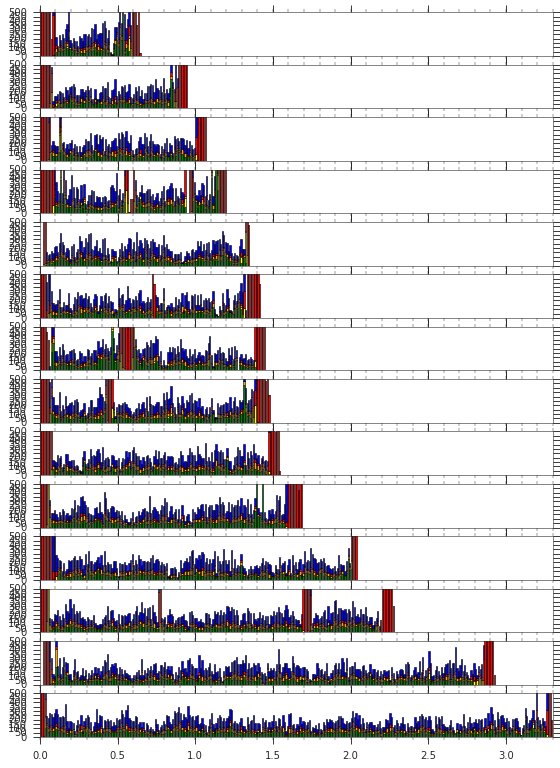

In [55]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(14, 1, figsize=(8.27, 11.69))
for i, chrom in enumerate(['Pf3D7_%02d_v3' % x for x in np.arange(1, 15)]):
    print(chrom)
    total_values = np.zeros(df_genomic_bin_summary_sum.loc[chrom].shape[0], int)
    for class_name in class_colours:
        current_values = df_genomic_bin_summary_sum.loc[chrom, class_name]
        axs[i].bar(
            df_genomic_bin_summary_sum.loc[chrom].index,
            current_values,
            bottom=total_values,
            color=class_colours[class_name]
        )
        total_values += current_values
    axs[i].set_xlim(0, 330)
    axs[i].set_ylim(0, 500)
    axs[i].xaxis.set_minor_locator(ticker.MultipleLocator(10))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(50))
    if i == 13:
        axs[i].set_xticklabels(np.arange(0, 3.5, 0.5))
    else:
        axs[i].set_xticklabels([])


In [56]:
fig.savefig("%s/variant_class_genome.pdf" % output_dir)

/nfs/users/nfs_r/rp7/miniconda3/envs/biipy/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Pf3D7_01_v3
Pf3D7_02_v3
Pf3D7_03_v3
Pf3D7_04_v3
Pf3D7_05_v3
Pf3D7_06_v3
Pf3D7_07_v3
Pf3D7_08_v3
Pf3D7_09_v3
Pf3D7_10_v3
Pf3D7_11_v3
Pf3D7_12_v3
Pf3D7_13_v3
Pf3D7_14_v3


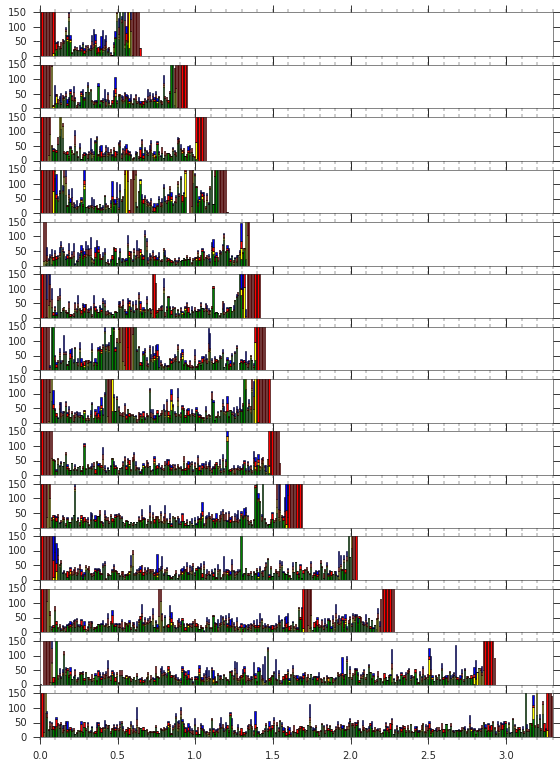

In [57]:
fig, axs = plt.subplots(14, 1, figsize=(8.27, 11.69))
for i, chrom in enumerate(['Pf3D7_%02d_v3' % x for x in np.arange(1, 15)]):
    print(chrom)
    total_values = np.zeros(df_genomic_bin_summary_sum_snp.loc[chrom].shape[0], int)
    for class_name in class_colours:
        current_values = df_genomic_bin_summary_sum_snp.loc[chrom, class_name]
        axs[i].bar(
            df_genomic_bin_summary_sum_snp.loc[chrom].index,
            current_values,
            bottom=total_values,
            color=class_colours[class_name]
        )
        total_values += current_values
    axs[i].set_xlim(0, 330)
    axs[i].set_ylim(0, 150)
    axs[i].xaxis.set_minor_locator(ticker.MultipleLocator(10))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(50))
    if i == 13:
        axs[i].set_xticklabels(np.arange(0, 3.5, 0.5))
    else:
        axs[i].set_xticklabels([])


In [58]:
fig.savefig("%s/variant_class_genome_snp.pdf" % output_dir)

/nfs/users/nfs_r/rp7/miniconda3/envs/biipy/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Pf3D7_01_v3
Pf3D7_02_v3
Pf3D7_03_v3
Pf3D7_04_v3
Pf3D7_05_v3
Pf3D7_06_v3
Pf3D7_07_v3
Pf3D7_08_v3
Pf3D7_09_v3
Pf3D7_10_v3
Pf3D7_11_v3
Pf3D7_12_v3
Pf3D7_13_v3
Pf3D7_14_v3


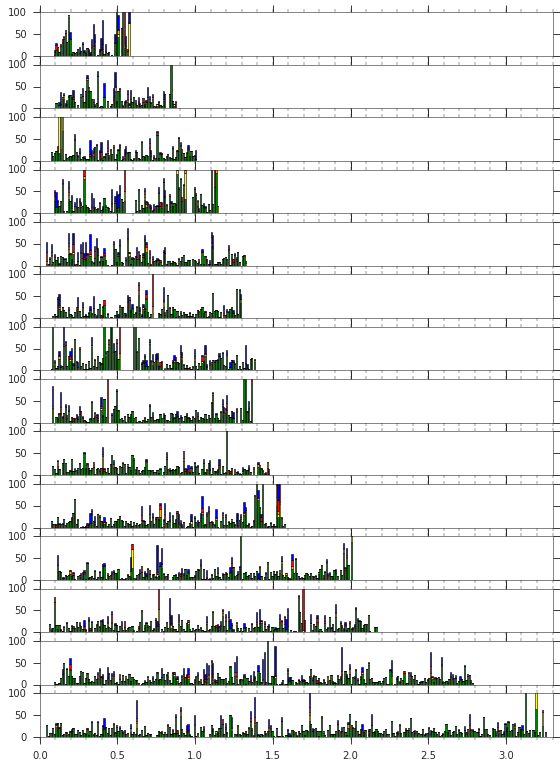

In [59]:
fig, axs = plt.subplots(14, 1, figsize=(8.27, 11.69))
for i, chrom in enumerate(['Pf3D7_%02d_v3' % x for x in np.arange(1, 15)]):
    print(chrom)
    total_values = np.zeros(df_genomic_bin_summary_sum_coding_snp.loc[chrom].shape[0], int)
    for class_name in class_colours:
        current_values = df_genomic_bin_summary_sum_coding_snp.loc[chrom, class_name]
        axs[i].bar(
            df_genomic_bin_summary_sum_coding_snp.loc[chrom].index,
            current_values,
            bottom=total_values,
            color=class_colours[class_name]
        )
        total_values += current_values
    axs[i].set_xlim(0, 330)
    axs[i].set_ylim(0, 100)
    axs[i].xaxis.set_minor_locator(ticker.MultipleLocator(10))
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(50))
    if i == 13:
        axs[i].set_xticklabels(np.arange(0, 3.5, 0.5))
    else:
        axs[i].set_xticklabels([])
    

In [60]:
fig.savefig("%s/variant_class_genome_coding_snp.pdf" % output_dir)

/nfs/users/nfs_r/rp7/miniconda3/envs/biipy/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
